In [1]:
import numpy as np

In [2]:
def binomial_call_full(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probs
    C = np.zeros([N + 1, N + 1])  # Call prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    for i in range(0, N + 1):
        C[N, i] = max(S_ini * (u ** (i)) * (d ** (N - i)) - K, 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
    return C[0, 0], C, S

Risk neutral probability is same for each step, at each step you can find call payoff when up step and also at down step and then get expected payoff using the p (risk-neutral) and then just discount it using risk free rate to get option payoff at time step t-1, then, you can just iterate back words to get the option payoff at time t=0 and that will be the option price, similar structure can be repeated for put option as below

In [3]:
def binomial_put_full(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probs
    P = np.zeros([N + 1, N + 1])  # Call prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    for i in range(0, N + 1):
        P[N, i] = max(K - (S_ini * (u ** (i)) * (d ** (N - i))), 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            P[j, i] = np.exp(-r * dt) * (p * P[j + 1, i + 1] + (1 - p) * P[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
    return P[0, 0], P, S

### Put call parity verification (read notes for better understanding)

In [9]:
put_price, P, S = binomial_put_full(100, 90, 10, 0, 1.2, 0.8, 10)
print("Price at t=0 for Put option is $", "{:.2f}".format(put_price))
call_price, C, S = binomial_call_full(100, 90, 10, 0, 1.2, 0.8, 10)
print("Price at t=0 for Call option is $", "{:.2f}".format(call_price))
print(f"{call_price - put_price}")

Price at t=0 for Put option is $ 19.38
Price at t=0 for Call option is $ 29.38
9.999999999999993


In [10]:
S_ini = 100
K = 90
T = 10
r = 0

print(f"{S_ini - K * np.exp(-r * T)}")

10.0


In [11]:
def call_option_delta(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta
    for i in range(0, N + 1):
        C[N, i] = max(S_ini * (u ** (i)) * (d ** (N - i)) - K, 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (
                S[j + 1, i + 1] - S[j + 1, i]
            )
    return C[0, 0], C, S, Delta

In [12]:
price_array = []
for N in [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000]:
    price, call, S, delta = call_option_delta(100, 90, 1, 0, 1.2, 0.8, N)
    price_array.append(price)
    print("With N = {:3d}, the price is {:.2f}".format(N, price))

With N =   1, the price is 15.00
With N =  10, the price is 29.38
With N = 100, the price is 70.32
With N = 200, the price is 85.40
With N = 300, the price is 92.33
With N = 400, the price is 95.84
With N = 500, the price is 97.70
With N = 600, the price is 98.71
With N = 700, the price is 99.27
With N = 800, the price is 99.58
With N = 900, the price is 99.76
With N = 1000, the price is 99.86
With N = 1500, the price is 99.99
With N = 2000, the price is 100.00


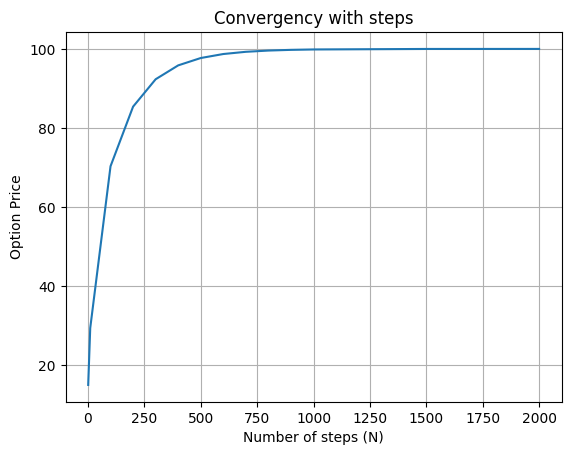

In [15]:
import matplotlib.pyplot as plt

N = [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000]
plt.plot(N, np.array(price_array))
plt.title("Convergency with steps")
plt.xlabel("Number of steps (N)")
plt.ylabel("Option Price")
plt.grid(True)
plt.show()

Why does option price converges to stock price if we increase the number of steps?

The reason is we have assumed constant up factor (1.2) and down factor (0.8) for all the steps, and ignoring the concept of **Volatility**, thus, you should adjust the volatility when you increase the number of steps in the binomial tree.

---

## 1. Adjusting $u$ and $d$ for Underlying Volatility

In [16]:
def call_option_delta_adjusting_vol(S_ini, K, T, r, sigma, N):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta
    for i in range(0, N + 1):
        C[N, i] = max(S_ini * (u ** (i)) * (d ** (N - i)) - K, 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (
                S[j + 1, i + 1] - S[j + 1, i]
            )
    return C[0, 0], C, S, Delta

In [17]:
price_array = []
for N in [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000]:
    call_price, C, S, delta = call_option_delta_adjusting_vol(100, 90, 1, 0, 0.3, N)
    price_array.append(call_price)
    print("With N = {:3d}, the price is {:.2f}".format(N, call_price))

With N =   1, the price is 19.14
With N =  10, the price is 17.26
With N = 100, the price is 17.02
With N = 200, the price is 17.03
With N = 300, the price is 17.01
With N = 400, the price is 17.02
With N = 500, the price is 17.01
With N = 600, the price is 17.02
With N = 700, the price is 17.02
With N = 800, the price is 17.01
With N = 900, the price is 17.01
With N = 1000, the price is 17.02
With N = 1500, the price is 17.01
With N = 2000, the price is 17.01


In [18]:
# Prices converge

In [54]:
price, call, S, delta = call_option_delta(100, 60, 3, 0.1, 1.2, 0.8, 3)

In [26]:
price, call, S, delta = call_option_delta_adjusting_vol(80, 90, 1, 0.1, 0.2, 1000)

In [30]:
put_price, P, S = binomial_put_full(36, 31, 50, 0.01, 1.2, 0.8, 50)